In [1]:
import torch
import torch.utils.data as Data
from datasets import load_dataset
from transformers import BertTokenizer
from transformers import BertModel
import torch.optim as optim
import time
from sklearn.metrics import accuracy_score
import copy
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class Dataset(Data.Dataset):
    """定义数据集"""

    def __init__(self, split):
        self.dataset = load_dataset(path='seamew/ChnSentiCorp', split=split)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        """定义索引方式"""
        text = self.dataset[i]['text']
        label = self.dataset[i]['label']
        return text, label


dataset_train = Dataset('train')  # torch.utils.data.Dataset

for text, label in dataset_train:
    # 调用__getitem__方法
    print(text)
    print(label)
    break

选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般
1


In [4]:
model_ckpt = "bert-base-chinese"

token = BertTokenizer.from_pretrained(model_ckpt)
print(token)

pretrained = BertModel.from_pretrained(model_ckpt)
print(pretrained)

# 冻结网络层参数(不进行梯度更新)
for param in pretrained.parameters():
    param.requires_grad = False

for weights in pretrained.parameters():
    print(weights.requires_grad, end=' ')  # 均为False

PreTrainedTokenizer(name_or_path='bert-base-chinese', vocab_size=21128, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [5]:
def get_collate_fn(tokenizer, max_len=512):
    """返回collate_fun函数(通过闭包函数引入形参)"""

    def collate_fn(data):
        sents = [i[0] for i in data]
        labels = [i[1] for i in data]

        # 批量编码句子
        data = tokenizer(text=sents,
                         truncation=True,
                         padding='max_length',
                         max_length=max_len,
                         return_token_type_ids=True,
                         return_attention_mask=True,
                         return_tensors='pt')

        input_ids = data['input_ids']
        attention_mask = data['attention_mask']
        token_type_ids = data['token_type_ids']
        labels = torch.LongTensor(labels)
        return input_ids, attention_mask, token_type_ids, labels

    return collate_fn


# 数据处理
dataloader_valid = torch.utils.data.DataLoader(dataset=Dataset('validation'),
                                               batch_size=16,
                                               collate_fn=get_collate_fn(token))

dataloader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                               batch_size=16,
                                               collate_fn=get_collate_fn(token),
                                               shuffle=True,
                                               drop_last=True)

print(len(dataloader_train))

for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(dataloader_train):
    print(input_ids)
    print(input_ids.shape)
    print(attention_mask)
    print(token_type_ids)
    print(labels)
    model_result = pretrained(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids)
    print(model_result.last_hidden_state.shape)
    break

600
tensor([[ 101,  831, 4157,  ...,    0,    0,    0],
        [ 101, 4696,  679,  ...,    0,    0,    0],
        [ 101,  122,  119,  ...,    0,    0,    0],
        ...,
        [ 101, 3766, 3300,  ...,    0,    0,    0],
        [ 101,  100, 5143,  ...,    0,    0,    0],
        [ 101, 2523, 1927,  ...,    0,    0,    0]])
torch.Size([16, 512])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([16, 512, 768])


In [6]:
class Model(torch.nn.Module):
    """下游训练任务模型"""

    def __init__(self, pretrained_model):
        super().__init__()
        self.fc = torch.nn.Linear(768, 2)  # 二分类任务
        self.pretrained = pretrained_model

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.pretrained(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids)

        out = self.fc(out.pooler_output)
        out = out.softmax(dim=1)  # 模型预测值
        return out

In [7]:
# 损失函数
criterion_cross_entropy = torch.nn.CrossEntropyLoss()

model_bert_base = Model(pretrained)
model_bert_base = model_bert_base.to(device)  # 模型设备切换

# 优化器
optimizer_adamw = optim.AdamW(model_bert_base.parameters(), lr=5e-4)  # 模型设备切换必须在优化器定义前执行

In [8]:
# 模型训练
def train(model, dataloader, criterion, optimizer, device, train_step_loss):
    model.train()
    
    predict_list = []
    y_true_list = []
    for idx, (input_ids, attention_mask, token_type_ids, labels) in enumerate(dataloader):
        # 数据设备切换
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        out = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids)
        
        predict_list.append(out.cpu())
        y_true_list.extend(labels.cpu().tolist())
        
        loss = criterion(out, labels)  # 每个step的损失值
        
        train_step_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()

        if idx % 100 == 0 and idx > 0:
            predict = out.argmax(dim=1).cpu().numpy()
            accuracy = accuracy_score(labels.cpu().numpy(), predict)  # 评估指标
            print('| step {:5d} | loss {:8.5f} | accuracy {:8.5f} |'.format(idx, loss.item(), accuracy))
    
    predict_all = torch.cat(predict_list, dim=0)  # 合并所有批次的预测结果
    y_true_all = torch.tensor(y_true_list)  # 真实标签
    accuracy = accuracy_score(y_true_all.numpy(), predict_all.argmax(dim=1).numpy())  # 训练数据集准确率
    return accuracy

In [9]:
# 模型验证
def evaluate(model, dataloader, device):
    model.eval()

    predict_list = []
    y_true_list = []
    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, labels in dataloader:
            # 数据设备切换
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            out = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)
            predict_list.append(out.cpu())
            y_true_list.extend(labels.tolist())

    predict_all = torch.cat(predict_list, dim=0)  # 合并所有批次的预测结果
    y_true_all = torch.tensor(y_true_list)  # 真实标签
    accuracy = accuracy_score(y_true_all.numpy(), predict_all.argmax(dim=1).numpy())  # 验证数据集准确率
    return accuracy

In [10]:
train_step_loss_list = []  # 训练数据集每个step的损失值
train_epoch_acc_list = []  # 训练数据集每个epoch的准确率
vaild_epoch_acc_list = []  # 验证数据集每个epoch的准确率
best_vaild_acc = 0.0  # 最佳模型验证数据集的准确率
best_model_state_dict = [None]  # 最佳模型的状态字典
EPOCHS = 5

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_acc = train(model_bert_base, dataloader_train, criterion_cross_entropy, optimizer_adamw, device, train_step_loss_list)
    vaild_acc = evaluate(model_bert_base, dataloader_valid, device)
    train_epoch_acc_list.append(train_acc)
    vaild_epoch_acc_list.append(vaild_acc)
    if vaild_acc > best_vaild_acc:
        best_vaild_acc = vaild_acc
        best_model_state_dict.pop()
        best_model_state_dict.append(copy.deepcopy(model_bert_base.state_dict()))
        
    print('-' * 89)
    print('| end of epoch {:5d} | time: {:5.2f}s | train accuracy {:8.5f} | valid accuracy {:8.5f} |'.format(epoch,
                                           time.time() - epoch_start_time, train_acc, vaild_acc))
    print('-' * 89)

| step   100 | loss  0.57169 | accuracy  0.81250 |
| step   200 | loss  0.42542 | accuracy  1.00000 |
| step   300 | loss  0.44033 | accuracy  0.93750 |
| step   400 | loss  0.45739 | accuracy  0.87500 |
| step   500 | loss  0.51319 | accuracy  0.75000 |
-----------------------------------------------------------------------------------------
| end of epoch     1 | time: 74.28s | train accuracy  0.79000 | valid accuracy  0.82583 |
-----------------------------------------------------------------------------------------
| step   100 | loss  0.54973 | accuracy  0.75000 |
| step   200 | loss  0.53969 | accuracy  0.81250 |
| step   300 | loss  0.40168 | accuracy  0.93750 |
| step   400 | loss  0.50014 | accuracy  0.81250 |
| step   500 | loss  0.46000 | accuracy  0.87500 |
-----------------------------------------------------------------------------------------
| end of epoch     2 | time: 74.12s | train accuracy  0.83323 | valid accuracy  0.81583 |
----------------------------------------

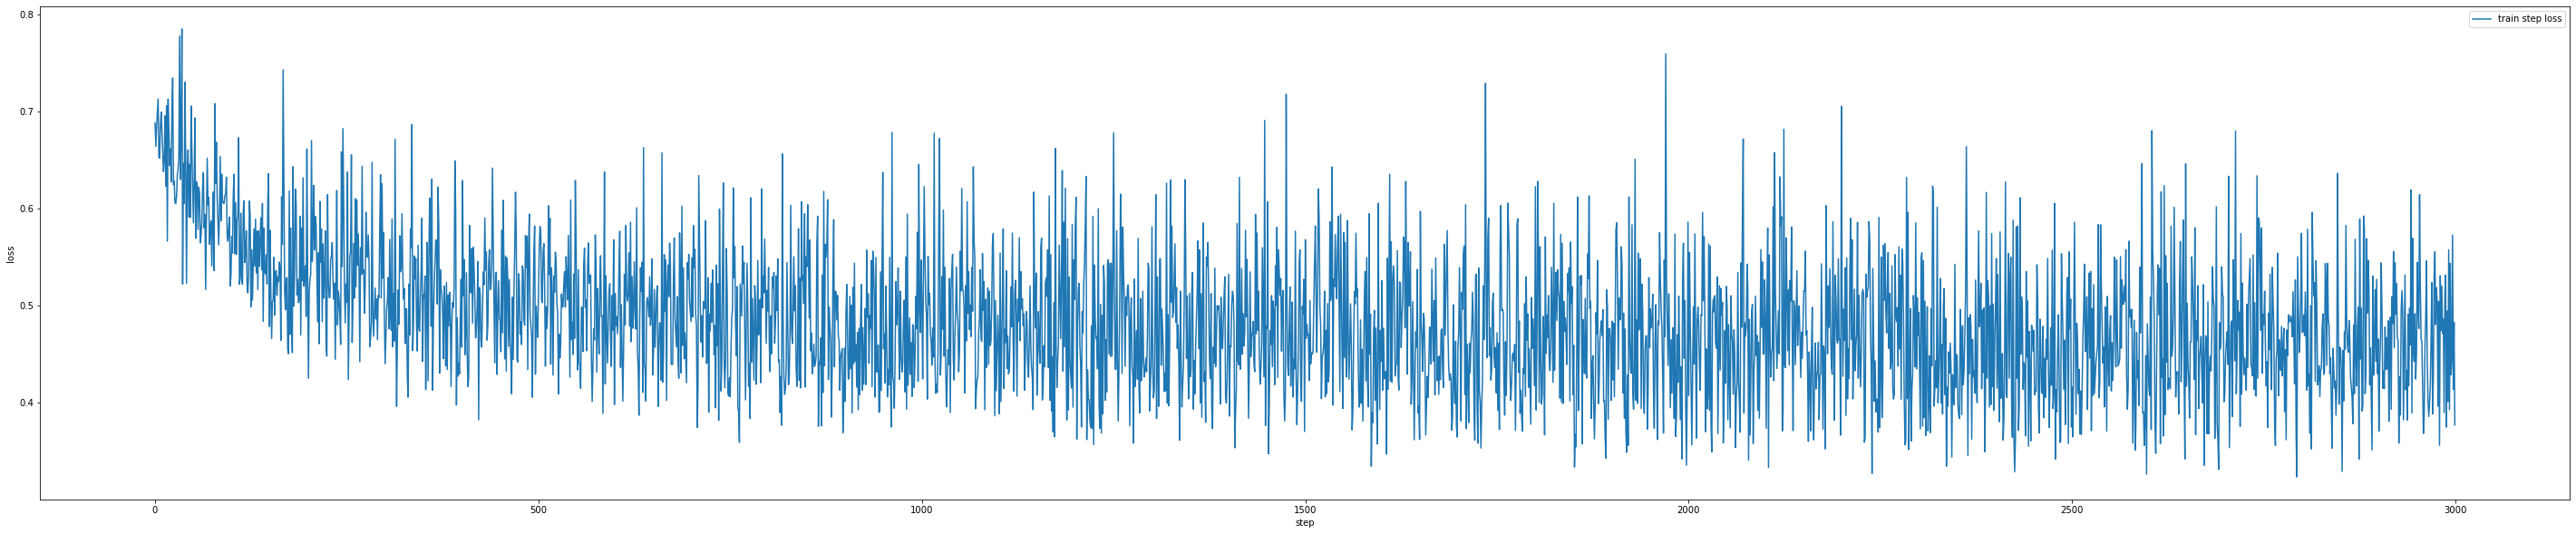

In [11]:
plt.figure(figsize=(50, 10))
plt.plot(train_step_loss_list, label='train step loss')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()
plt.show()

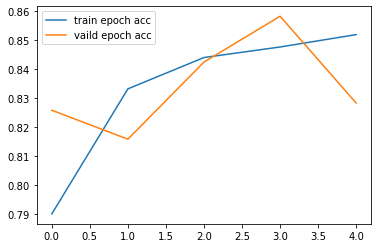

In [12]:
plt.plot(train_epoch_acc_list, label='train epoch acc')
plt.plot(vaild_epoch_acc_list, label='vaild epoch acc')
plt.legend()
plt.show()

In [13]:
model_best = Model(pretrained)
model_best.load_state_dict(best_model_state_dict[0])
model_best  # 最佳模型验证数据集的准确率对应的模型

Model(
  (fc): Linear(in_features=768, out_features=2, bias=True)
  (pretrained): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNo

In [16]:
model_best = model_best.to(device) 
vaild_acc_best = evaluate(model_best, dataloader_valid, device)
print(vaild_acc_best)
print(best_vaild_acc)  # 结果与上一致

0.8583333333333333
0.8583333333333333
